In [144]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [145]:
from keras.datasets.mnist import load_data
(X_train, y_train), (X_test, y_test) = load_data()

X_train = torch.tensor([x.flatten() for x in X_train]).float()
y_train = torch.tensor(y_train)
X_test = torch.tensor([x.flatten() for x in X_test]).float()
y_test = torch.tensor(y_test)

X_train = X_train / 255.
X_test = X_test / 255.

In [146]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(784,128)
    self.L1 = nn.Linear(128,20)
    self.L2 = nn.Linear(20,128)
    self.output = nn.Linear(128,784)

  def forward(self,x):
    x = nn.functional.relu(self.input(x))
    x = nn.functional.relu(self.L1(x))
    x = nn.functional.relu(self.L2(x))
    x = torch.sigmoid(self.output(x))
    return x

In [147]:
def create_model():
  model = Model()
  loss = nn.MSELoss()
  opt = torch.optim.Adam(model.parameters(),lr=0.001)
  return model,loss,opt

In [148]:
def train_the_model(X_train,nb_epochs,mb_size,X_test):
  losses = []
  testlosses = []
  minibatches_X = [X_train[k:k+mb_size] for k in range(0,len(X_train),mb_size)]
  minibatches_y = [y_train[k:k+mb_size] for k in range(0,len(X_train),mb_size)]
  for i in tqdm.trange(nb_epochs):
    for (X,y) in zip(minibatches_X,minibatches_y):
      pred = model(X)
      l = loss(pred,X)

      opt.zero_grad()
      l.backward()
      opt.step()
    #compute losses
    pred = model(X_train[:len(X_test)])
    losses.append(loss(pred,X_train[:len(X_test)]).item())
    pred = model(X_test)
    testlosses.append(loss(pred,X_test).item())
  return testlosses,losses

In [149]:
model,loss,opt = create_model()
testlosses,losses = train_the_model(X_train,20,32,X_test)

100%|██████████| 20/20 [02:35<00:00,  7.78s/it]


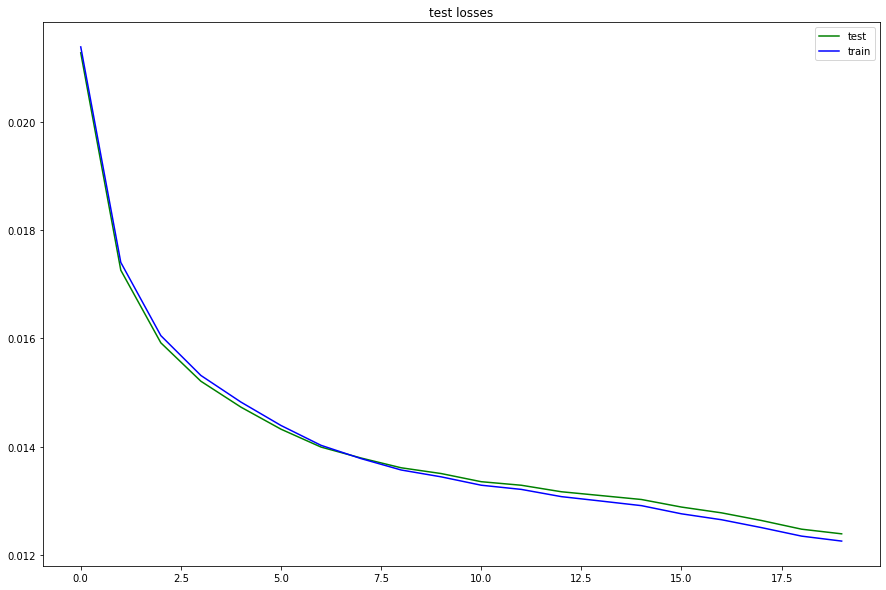

In [150]:
plt.figure(figsize=(15,10))
plt.title("test losses")
plt.plot(testlosses,"g",label="test")
plt.plot(losses,"b",label="train")
plt.legend()

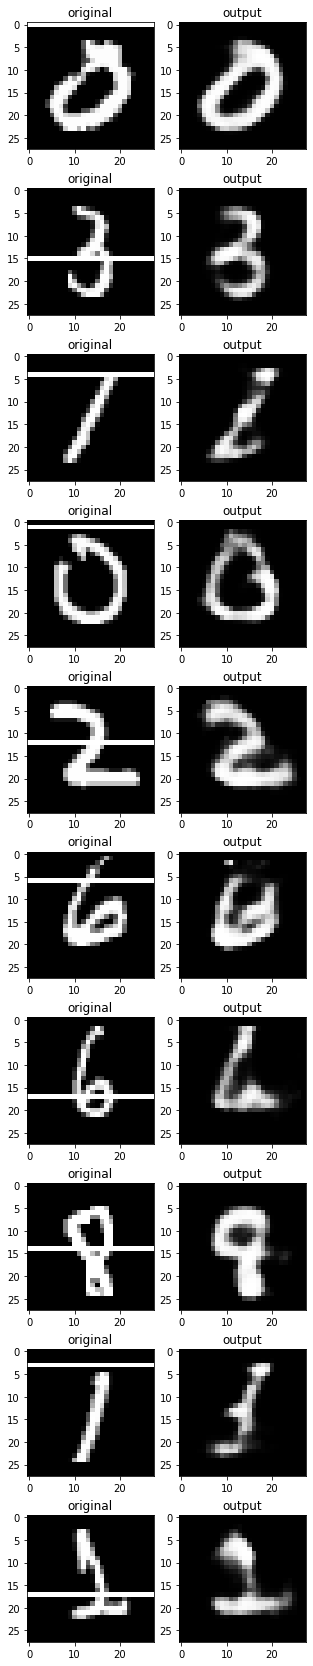

In [152]:
plt.figure(figsize=(5,30))
for k in range(1,21,2):
  i=np.random.randint(len(X_train))
  rowstart = np.random.randint(20)
  occluded = X_train[i].detach().numpy() + np.array([0]*28*rowstart+[1]*1*28+[0]*28*(28-1-rowstart))
  occluded = torch.tensor([1 if i>1 else i for i in occluded]).float()
  res = model(occluded)
  plt.subplot(10,2,k)
  plt.title("original")
  plt.imshow(occluded.reshape((28,28)),"gray")
  plt.subplot(10,2,k+1)
  plt.title("output")
  plt.imshow(res.detach().numpy().reshape((28,28)),"gray")

In [161]:
#make a model from just the two first modules of model
d = dict()
for mod in model.named_modules():
  d[mod[0]]=mod[1]
d = [d['input'],d['L1']]
newmodel = nn.Sequential(
    d[0],
    nn.ReLU(),
    d[1]
)

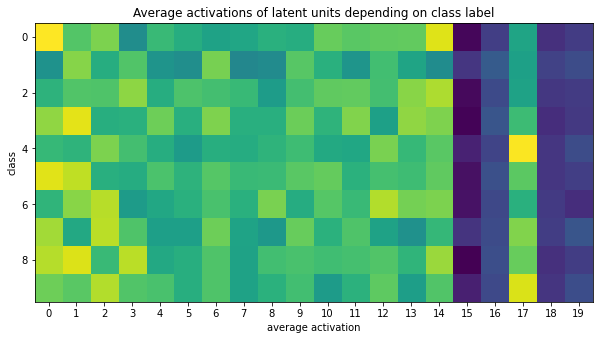

In [178]:
#get average value of each code unit for each digit
avg = []
for i in range(10):
  arg = np.where(y_test==i)
  ims = X_test[arg]
  units = [newmodel(x).detach().numpy() for x in ims]
  units = np.array(units)
  avg.append(np.mean(units,axis=0))
avg = np.array(avg)
plt.figure(figsize=(10,10))
plt.title("Average activations of latent units depending on class label")
plt.xlabel("average activation")
plt.xticks(ticks=list(range(20)))
plt.ylabel("class")
_=plt.imshow(avg)

tensor([ 9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
         9.,  9.,  9., 13.,  0.,  0.])


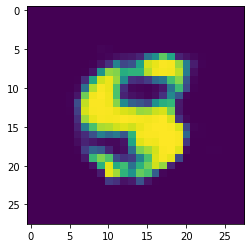

In [191]:
#briefly try to generate a 4 based on last cell
code = [np.random.randint(10)]*17+[13]+[0]*2
#get the generator/decoder part of the net
d = dict()
for mod in model.named_modules():
  d[mod[0]]=mod[1]
d = [d['L2'],d['output']]
newmodel = nn.Sequential(
    d[0],
    nn.ReLU(),
    d[1],
    nn.Sigmoid()
)
code = torch.tensor(code).float()
print(code)
im = newmodel(code).detach().numpy()
plt.imshow(im.reshape(28,28))